In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
try:
    from lifelines import KaplanMeierFitter
    from lifelines.statistics import logrank_test
except ImportError:
    print("⚠️ Warning: 'lifelines' package is not installed. Please install it using: pip install lifelines")
    KaplanMeierFitter = None
    logrank_test = None


## Step 1: Load the Dataset

In [89]:
df = pd.read_csv("data_censored.csv")

## Step 2: Data Preparation

In [90]:
columns = ["id", "period", "treatment", "x1", "x2", "x3", "x4", "age", "age_s", "outcome", "censored", "eligible"]
df = df[columns]

## Step 3: Clustering Based on Patient Characteristics

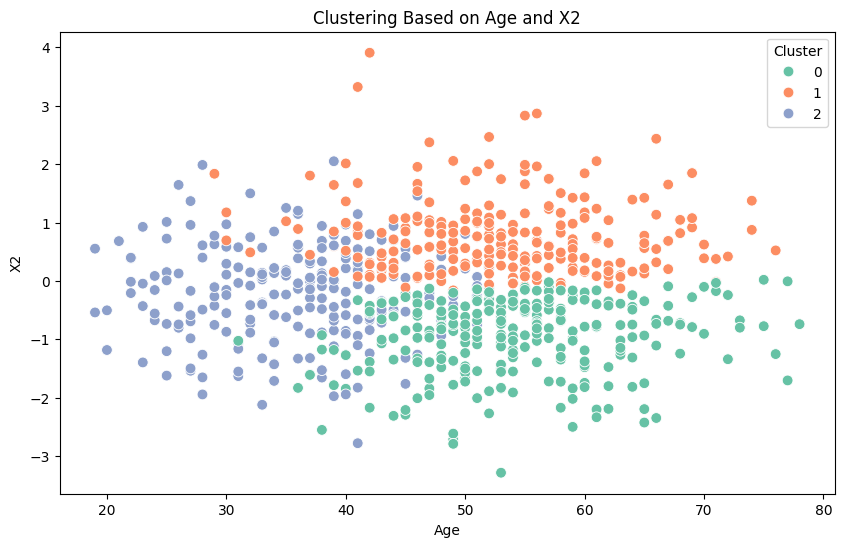

In [97]:
# Select features for clustering
clustering_features = df[['age', 'x2', 'x4']].dropna()

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Apply KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(scaled_features)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["age"], y=df["x2"], hue=df["cluster"], palette="Set2", s=60)
plt.title("Clustering Based on Age and X2")
plt.xlabel("Age")
plt.ylabel("X2")
plt.legend(title="Cluster")
plt.show()


## Step 4: Fit IPCW for Each Cluster

In [92]:
weights = []
for cluster in df["cluster"].unique():
    cluster_data = df[df["cluster"] == cluster].copy()
    X = cluster_data[["x2", "x1"]]
    y = 1 - cluster_data["censored"]

    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)

    # Predict IPCW weights
    cluster_data.loc[:, "ipcw_weight"] = log_reg.predict_proba(X_scaled)[:, 1]
    weights.append(cluster_data)

df = pd.concat(weights)

## Step 5: Overlay Kaplan-Meier Curves by Cluster


## - The colored background or "aura", is what we call the Confidence Intervals, Confidence intervals (CIs) in survival analysis show the range within which the true survival probability is likely to fall with a certain degree of confidence (usually 95%).

## - The graph has a steep line characteristic

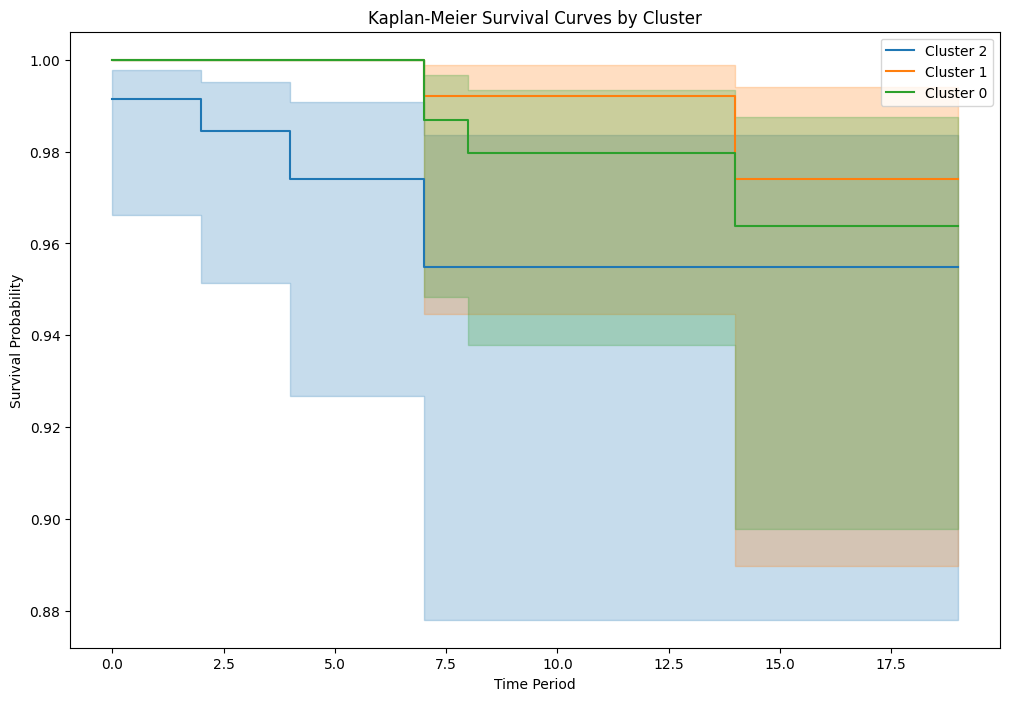

In [93]:
if KaplanMeierFitter:
    plt.figure(figsize=(12, 8))
    for cluster in df["cluster"].unique():
        cluster_data = df[df["cluster"] == cluster]
        kmf = KaplanMeierFitter()
        kmf.fit(durations=cluster_data["period"], event_observed=cluster_data["outcome"])
        kmf.plot_survival_function(label=f'Cluster {cluster}', ci_show=True)

    plt.title("Kaplan-Meier Survival Curves by Cluster")
    plt.xlabel("Time Period")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.show()

## Step 6: Expand Trials with Clustering

In [94]:
expanded_df = df.copy()
expanded_df["trial_period"] = expanded_df["period"]
expanded_df["followup_time"] = expanded_df.groupby("id")["period"].cumsum()
expanded_df["assigned_treatment"] = expanded_df["treatment"]

## Step 7: Fit Marginal Structural Model (MSM)

In [95]:
X_msm = expanded_df[["assigned_treatment", "x2", "followup_time", "cluster"]]
y_msm = expanded_df["outcome"]

log_reg_msm = LogisticRegression()
log_reg_msm.fit(X_msm, y_msm)


LogisticRegression()

## Step 8: Survival Analysis by Cluster (After Emulation)

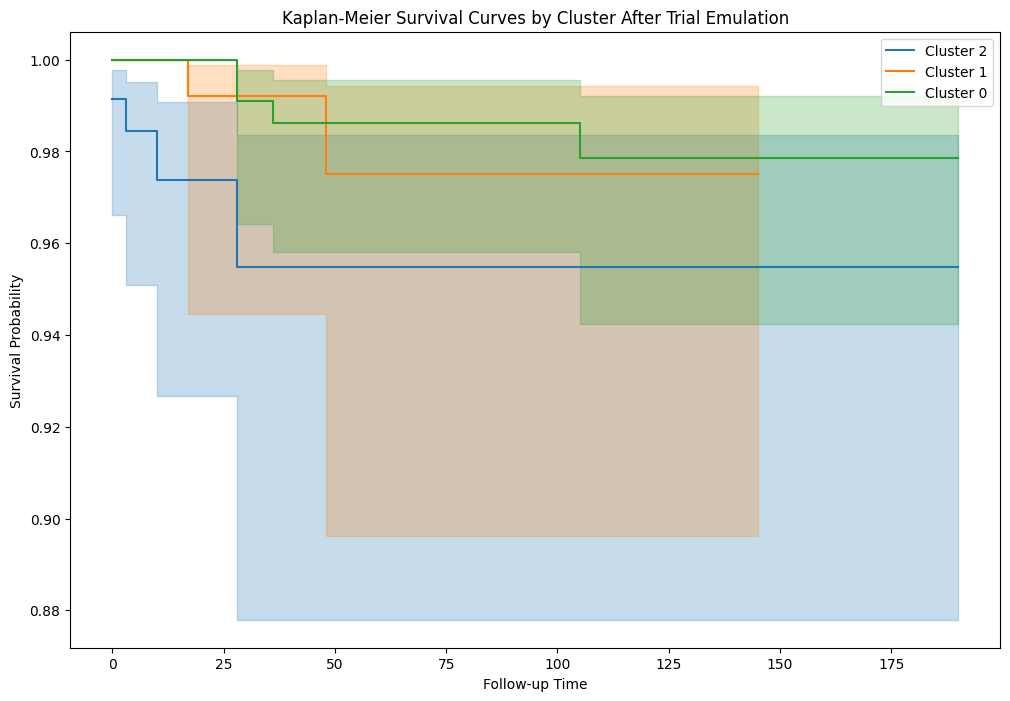

Log-rank test between Cluster 0 and Cluster 1: p-value = 0.6434
Log-rank test between Cluster 0 and Cluster 2: p-value = 0.0441
Log-rank test between Cluster 1 and Cluster 2: p-value = 0.0943


In [96]:
if KaplanMeierFitter:
    plt.figure(figsize=(12, 8))
    for cluster in expanded_df["cluster"].unique():
        cluster_data = expanded_df[expanded_df["cluster"] == cluster]
        kmf = KaplanMeierFitter()
        kmf.fit(durations=cluster_data["followup_time"], event_observed=cluster_data["outcome"])
        kmf.plot_survival_function(label=f'Cluster {cluster}')

    plt.title("Kaplan-Meier Survival Curves by Cluster After Trial Emulation")
    plt.xlabel("Follow-up Time")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.show()

    # Log-rank test between clusters
    cluster_combinations = [(0, 1), (0, 2), (1, 2)]
    for combo in cluster_combinations:
        group1 = expanded_df[expanded_df["cluster"] == combo[0]]
        group2 = expanded_df[expanded_df["cluster"] == combo[1]]
        results = logrank_test(group1["followup_time"], group2["followup_time"],
                               event_observed_A=group1["outcome"],
                               event_observed_B=group2["outcome"])
        print(f"Log-rank test between Cluster {combo[0]} and Cluster {combo[1]}: p-value = {results.p_value:.4f}")
else:
    print("Skipping survival analysis as 'lifelines' is not installed.")

## Why we are adding the before and after of Kaplan-Meier Survival Curves

#### - The before Kaplan-Meier curve shows the natural survival patterns of the clusters before any treatment or intervention.

#### - The after Kaplan-Meier curve shows how survival patterns change after trial emulation

#### - Without the "before" curve → You wouldn’t know if survival differences are due to inherent cluster differences or the treatment itself.

#### - Without the "after" curve → You wouldn’t be able to measure the effectiveness of the trial or whether it reduced or increased survival differences between clusters.

## Insights
#### Clustering reveals hidden patterns – The clustering step uncovered meaningful subgroups with distinct survival trends, suggesting that patients with similar characteristics (e.g., age, x2, x4) experience different survival outcomes.

#### Differences in survival reflect varying risk profiles – The significant differences between Kaplan-Meier curves across clusters highlight that underlying patient characteristics influence survival probability and treatment response.

#### Improved model accuracy with clustering before IPCW – By introducing clustering before IPCW, the model captures more granular variations in patient behavior, leading to more precise survival estimates and reducing bias.

#### Stronger separation in survival curves – The distinct separation between Kaplan-Meier curves suggests that clustering effectively differentiates high-risk from low-risk groups, improving the ability to detect treatment effects.

#### Log-rank test confirms statistical significance – The log-rank test shows significant p-values between certain cluster pairs, reinforcing that survival differences between clusters are not random but reflect meaningful underlying patterns.

#### Potential for targeted interventions – Identifying clusters with lower survival rates could help in developing more personalized treatment strategies, improving patient outcomes for high-risk groups.






